# Extract ObjectTables Results in  OGA

 work with Weakly_2023_44
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/12/21
- update : 2023/12/22


In [1]:
! eups list -s | grep LOCAL

analysis_tools        LOCAL:/home/d/dagoret/repos/repos_w_2023_44/analysis_tools 	setup
atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2023_44/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2023_44/Spectractor 	setup


In [2]:
! eups list -s lsst_distrib

   g4213664e8e+d053631def 	current w_2023_44 setup


In [3]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.visualization import ZScaleInterval, LinearStretch, ImageNormalize


from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# LSST packages
from lsst.daf.butler import Butler
import lsst.geom as geom

# allow interactive plots
#%matplotlib widget
%matplotlib inline

# default plot style is accessible
plt.style.use('tableau-colorblind10')

In [4]:
# A repo which exists at the USDF, contains data from various instruments and
REPO = '/repo/embargo'

from lsst.daf.butler import Butler
from pprint import pprint

# Here we specify a default collection to use
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"
butler = Butler(REPO, collections=my_collection)
registry = butler.registry

In [5]:
list(butler.registry.queryDimensionRecords('detector', where="instrument='LATISS' AND detector.id IN (0..8)"))

[detector.RecordClass(instrument='LATISS', id=0, full_name='RXX_S00', name_in_raft='RXX_S00', raft=None, purpose='SCIENCE')]

### access to skymap

https://github.com/sylvielsstfr/MyDP0LSS/blob/main/myDP0.2/TrackAndPatch/PlotTractAndPatchs_butler.ipynb

In [6]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

## Config

In [7]:
datasetRefs = butler.registry.queryDatasets(datasetType='skyMap', collections=my_collection, where= "instrument='LATISS'")

In [8]:
for i, ref in enumerate(datasetRefs):
    pprint(ref)
    skymap_id = ref.dataId["skymap"]
    if skymap_id ==  'latiss_v1':
        skymap = ref

DatasetRef(DatasetType('skyMap', {skymap}, SkyMap), {skymap: 'hsc_rings_v1'}, run='skymaps', id=6e7fc928-0dc3-4e1b-ae63-5fb63be46216)
DatasetRef(DatasetType('skyMap', {skymap}, SkyMap), {skymap: 'latiss_v1'}, run='skymaps', id=f677ff86-2b1c-4094-9dad-e39395052cd1)
DatasetRef(DatasetType('skyMap', {skymap}, SkyMap), {skymap: 'lsst_cells_v1'}, run='skymaps', id=857e0e80-8d08-44f4-a81b-84227b064d5b)


In [9]:
skymap = butler.get(ref)

In [10]:
my_tracts = [ 5616,5634,5615,10644,383,8188,3863,455,452,5839,10643,382]

In [11]:
#from lsst.daf.butler import Butler
#butler = Butler('SMALL_HSC')
skymap = butler.get('skyMap', skymap='latiss_v1', collections=my_collection)
tractInfo = skymap.generateTract(5616)
#patch = tractInfo[41]
#patch.getIndex()

In [12]:
#for patch in tractInfo:
#    print(patch.getSequentialIndex())

In [13]:
# Load data (deserialize)
import pickle
with open('Latiss_tractspatchs.pickle', 'rb') as handle:
    tracts_patchs_dict = pickle.load(handle)

In [14]:
tracts_patchs_dict

{5616: array([335, 355, 358, 336, 337, 338, 316, 357, 317, 356]),
 5634: array([ 91,  52,  93,  72,  92, 109, 110,  54,  71,  53,  55, 112, 111,
         74,  73,  90]),
 5615: array([332, 333, 312, 313, 295, 331, 276, 275, 294, 293, 314, 274]),
 10644: array([166, 184, 183, 201, 161, 180, 207, 188, 202, 182, 189, 208, 164,
        181, 185, 165, 203, 162]),
 383: array([359, 360]),
 8188: array([48, 65, 47, 28, 46, 66, 27]),
 3863: array([241, 243, 242, 260, 261, 222, 262, 224, 223]),
 455: array([52, 33, 51, 32, 14, 53, 34, 15, 13]),
 452: array([42, 44, 25, 24, 63, 23, 43, 62]),
 5839: array([9, 7, 8]),
 10643: array([171, 190]),
 382: array([343, 342])}

In [15]:
list_of_tracts = list(tracts_patchs_dict.keys())
list_of_tracts

[5616, 5634, 5615, 10644, 383, 8188, 3863, 455, 452, 5839, 10643, 382]

In [16]:
npatches = 0
for itract in list_of_tracts:
    npatches += len(tracts_patchs_dict[itract])
print(npatches)    

98


In [17]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

numTracts=0
# collection of polygons
patches = [] # container of all polygons


tract_polygon_dict = {}
tract_ra_dict = {}
tract_dec_dict = {}

# loop on tracts
#---------------
for tractInfo in skymap:
    tractID = tractInfo.getId()
    if tractID not in list_of_tracts:
        continue
    numTracts+=1  

    # container for each tract
    container_polygons_fortract = []
    container_ra_fortract = []
    container_dec_fortract = []


    # loop on patch
    #--------------
    for patch in tractInfo:
        patchID = patch.getSequentialIndex()
        if patchID not in tracts_patchs_dict[tractID]:
            continue
        ibb=patch.getInnerBBox()
        tWCS=tractInfo.getWcs()
        corners = []
        # loop on the 4 corners
        for icorn,corner in enumerate(ibb.getCorners()):
            p = geom.Point2D(corner.getX(), corner.getY())
            coord = tWCS.pixelToSky(p)
            corners.append([coord.getRa().asDegrees(), coord.getDec().asDegrees()])
            container_ra_fortract.append(coord.getRa().asDegrees()) 
            container_dec_fortract.append(coord.getDec().asDegrees()) 
        #print(f"==={numTracts}==={tractID}:{patchID}==========")    
        corners_array = np.array(corners)
        #print(corners_array)
        polygon = Polygon(corners_array,True)
        patches.append(polygon)
        container_polygons_fortract.append(polygon)
        
        
    tract_polygon_dict[tractID] = container_polygons_fortract
    tract_ra_dict[tractID] = np.array(container_ra_fortract)
    tract_dec_dict[tractID] = np.array(container_dec_fortract)
    
    
        
print(numTracts)   



/tmp/ipykernel_9890/1620158342.py:50: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = Polygon(corners_array,True)


12


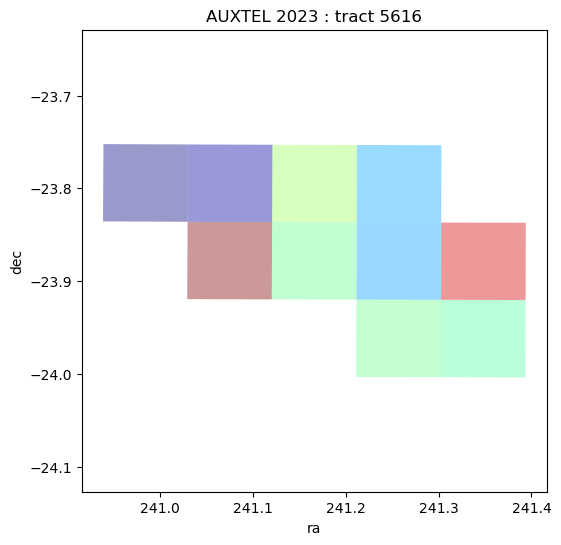

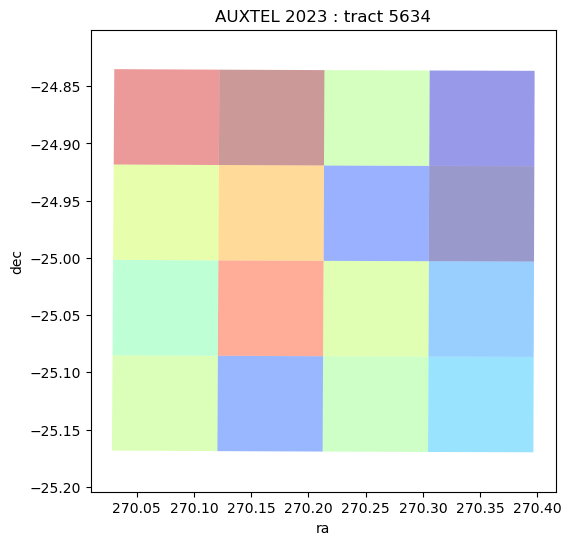

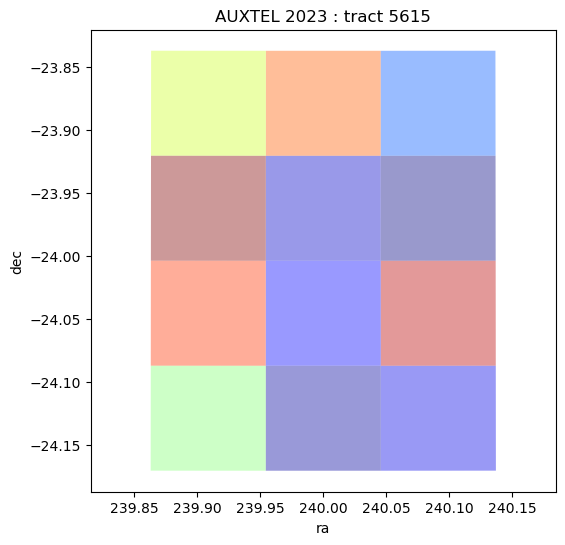

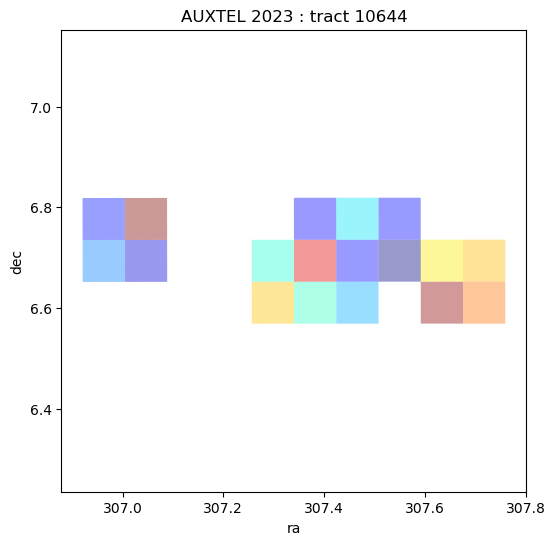

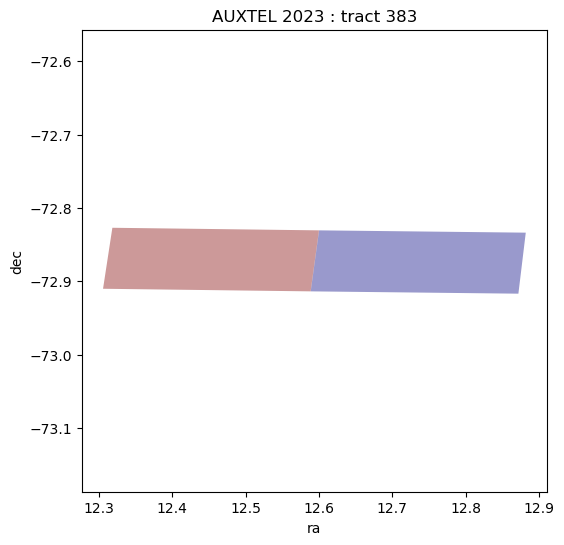

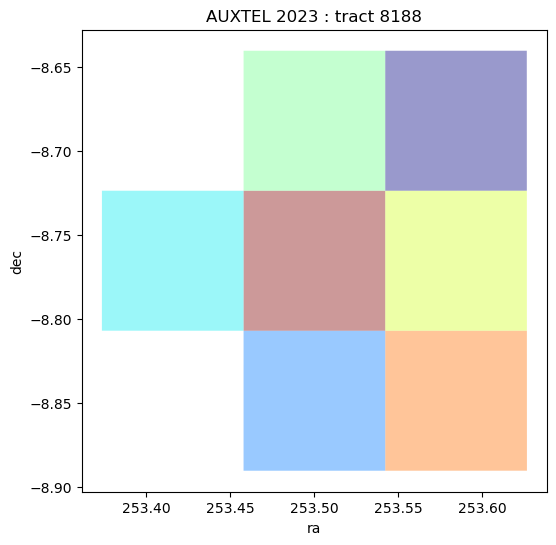

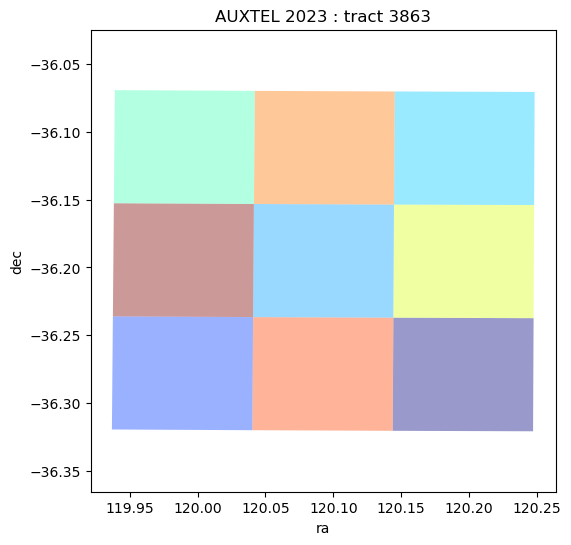

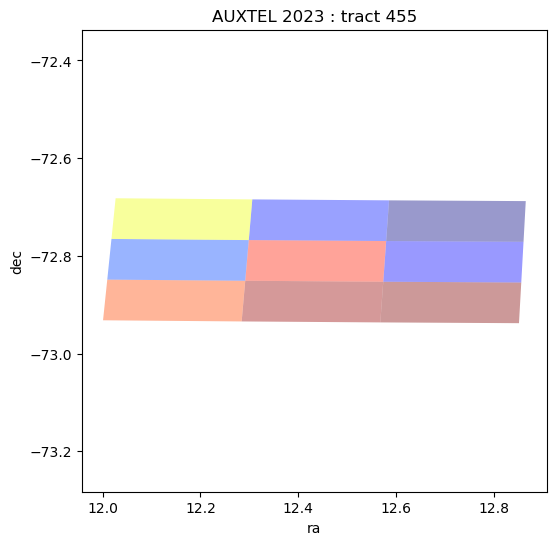

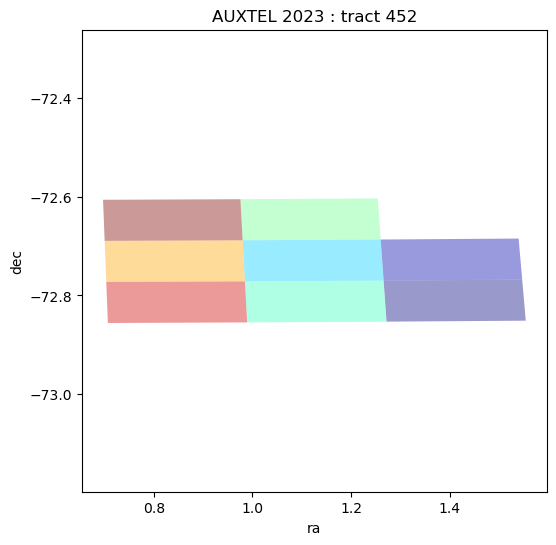

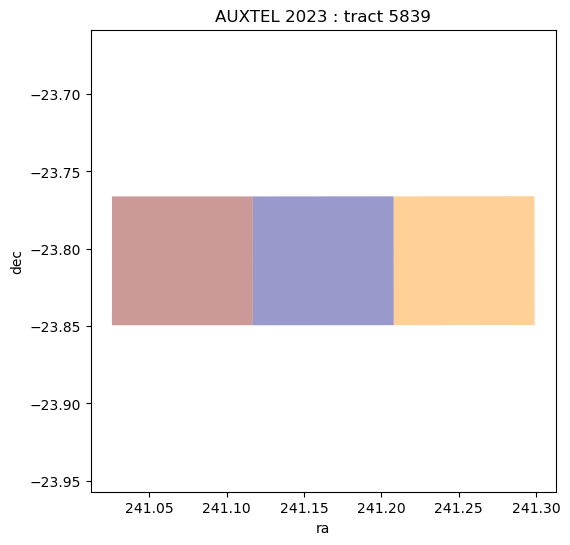

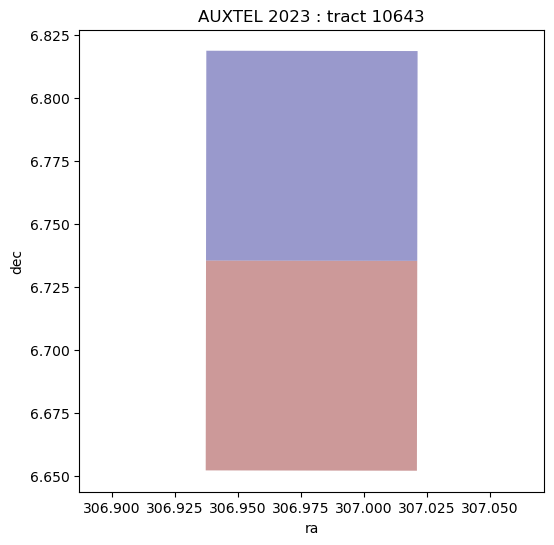

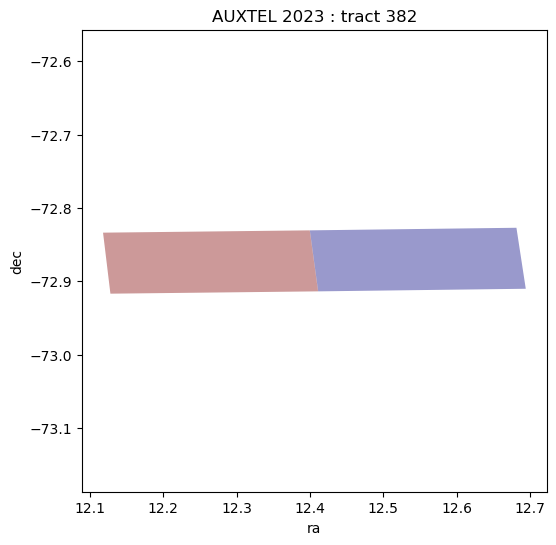

In [23]:
for itract in list_of_tracts:
    patches = tract_polygon_dict[itract]
    ra = tract_ra_dict[itract]
    dec = tract_dec_dict[itract]
    Xmin = ra.min()
    Xmax = ra.max()
    Ymin = dec.min()
    Ymax = dec.max()
    

    fig, ax = plt.subplots(figsize=(6,6))
    p = PatchCollection(patches, cmap=mpl.cm.jet, alpha=0.4)

    colors = 50*np.random.rand(len(patches))
    p.set_array(np.array(colors))

    ax.add_collection(p)  


    ax.set_xlim([Xmin,Xmax])
    ax.set_ylim([Ymin, Ymax])

    title = f"AUXTEL 2023 : tract {itract}"
    ax.set_title(title)
    ax.set_xlabel("ra")
    ax.set_ylabel("dec")
    #plt.gca().set_aspect('equal')
    ax.axis('equal')
    plt.show()

In [22]:
#
#fig=plt.figure()
#ax = fig.add_subplot(projection=wcs)
#ax.imshow(hdu[0].data, origin='lower')
#ax.grid(color='white', ls='solid')
#ax.set_xlabel('RA')
#ax.set_ylabel('DEC')
#ax.scatter(coord.ra.deg, coord.dec.deg, s=300, edgecolor='white', facecolor='none',transform=ax.get_transform('icrs'))
#ax.set_title(target_name_ned)